## Historic Drought Analysis

This notebook steps through an analysis of droughts in the DRB, assessing droughts using multiple different metrics including:
- Exceedance probability
- Severity
- Duration

Droughts are classified using the Standardized Streamflow Index (SSI).

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.stats as scs
import spei as si


from utils.drought_plots import plot_ssi

# Directory to pywrdrb project
pywrdrb_directory = '../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches

In [2]:
def get_drought_metrics(ssi):
    """Get drought start and end dates, magnitude, severity, and duration.

    Args:
        ssi (pd.Series): Array of SSI values.  

    Returns:
        pd.DataFrame: DataFrame containing all drought metrics for each drought period.
    """
    
    drought_data = {}
    drought_counter = 0
    in_critical_drought = False
    drought_days = []

    for ind in range(len(ssi)):
        if ssi.values[ind] < 0:
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':ssi.index[drought_days[0]],
                    'end': ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(ssi.values[drought_days]),
                    'severity': min(ssi.values[drought_days])
                }
            
            # Reset counters
            in_critical_drought = False
            drought_days = [] 

    drought_metrics = pd.DataFrame(drought_data).transpose()
    return drought_metrics

In [3]:
# Model generation specifications
full_date_range = ('1945-01-01', '2022-12-31')

# Constants
cms_to_mgd = 22.82
fdc_quantiles = [0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]

In [4]:
Q_reconst = pd.read_csv(f'./outputs/historic_reconstruction_daily_nhmv10_NYCScaled_mgd.csv', sep = ',', index_col = 0, parse_dates = True)
nyc_reservoirs = ['cannonsville', 'pepacton', 'neversink']

# Q_reconst = Q_reconst.loc[:'1970-01-01',:]
# Sum inflows by node
Q_reconst_nodes = pd.DataFrame(index=Q_reconst.index, columns=obs_pub_site_matches.keys())
for node in Q_reconst_nodes.columns:
    if obs_pub_site_matches[node] is not None:
        Q_reconst_nodes.loc[:,node] = Q_reconst.loc[:, obs_pub_site_matches[node]].sum(axis=1)
    else:
        Q_reconst_nodes.loc[:,node] = Q_reconst.loc[:, node]
Q_reconst_nodes["Total NYC Inflow"] = Q_reconst_nodes.loc[:,nyc_reservoirs].sum(axis=1)
Q_reconst_nodes["Basin Total"] = Q_reconst_nodes.sum(axis=1)

In [12]:
# Rolling sum
consider_nodes = ['pepacton', 'Total NYC Inflow', 'Basin Total', 'blueMarsh', 'beltzvilleCombined', 'delTrenton']
Q_rsum = Q_reconst.rolling("365D").sum().dropna()
Q_nodes_rsum = Q_reconst_nodes.rolling("365D").sum().dropna()

node_ssi = pd.DataFrame(index = Q_rsum.index, columns=consider_nodes)
for node in node_ssi.columns:
    node_ssi[node] = si.ssfi(Q_nodes_rsum[node], dist = scs.gamma)

node_ssi = node_ssi.loc['1946-01-01':,:]

# cannonsville_gammfit_plot = si.plot.dist(Q_nodes_rsum['cannonsville'], scs.gamma, cumulative=True, legend = False)

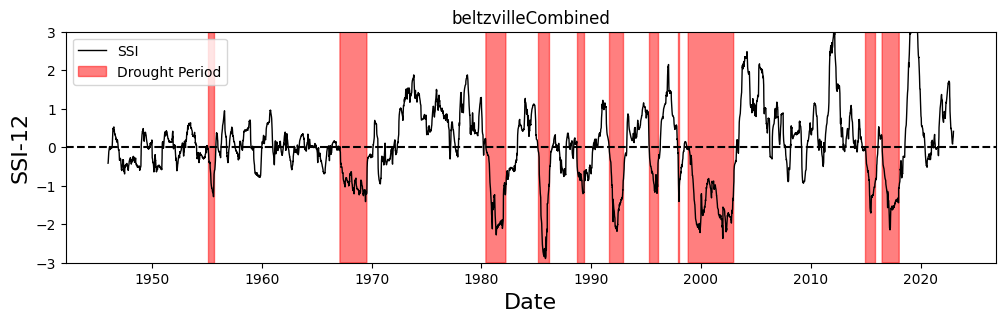

In [17]:
plot_nodes = ['beltzvilleCombined']
# plot_nodes = ['pepacton']
t_start='1946-01-01'
t_end='2022-12-31'

fig, ax = plt.subplots(nrows=len(plot_nodes), ncols=1, figsize = (12, len(plot_nodes)*3), sharex = True)
plot_ssi(node_ssi.loc[t_start:t_end, plot_nodes[0]], ax = ax)
ax.set_title(plot_nodes[0])
plt.xlabel('Date', fontsize=16)
plt.ylabel('SSI-12', fontsize=16)
plt.legend(loc='upper left')
plt.show()

In [18]:

drought_data = {}
drought_counter = 0
for node in plot_nodes:
    ssi = node_ssi[node]
    in_drought = False
    in_critical_drought = False

    drought_days = []

    for ind in range(len(ssi)):
        if ssi.values[ind] < 0:
            in_drought = True
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':ssi.index[drought_days[0]],
                    'end': ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(ssi.values[drought_days]),
                    'severity': min(ssi.values[drought_days]),
                    'node': node
                }
                
            in_drought = False
            in_critical_drought = False
            drought_days = [] 

drought_metrics = pd.DataFrame(drought_data).transpose()
# drought_metrics = drought_metrics.drop(1, axis=0).reset_index()
drought_metrics


,start,end,duration,magnitude,severity,node
1,1955-01-27,1955-10-25,272,-178.431501,-1.285066,beltzvilleCombined
2,1967-02-14,1970-02-17,1100,-886.329619,-1.412997,beltzvilleCombined
3,1980-05-31,1983-04-15,1050,-1145.300639,-2.278058,beltzvilleCombined
4,1985-02-21,1986-06-14,479,-708.75032,-2.891093,beltzvilleCombined
5,1988-09-08,1990-03-05,544,-383.636711,-1.207211,beltzvilleCombined
6,1991-08-21,1993-03-29,587,-689.682946,-2.186276,beltzvilleCombined
7,1995-04-13,1996-04-15,369,-242.019203,-1.198937,beltzvilleCombined
8,1997-11-14,1998-06-15,214,-117.913859,-1.409883,beltzvilleCombined
9,1998-11-03,2003-03-24,1603,-2179.739329,-2.368721,beltzvilleCombined
10,2014-12-22,2016-02-15,421,-369.763812,-1.705238,beltzvilleCombined


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


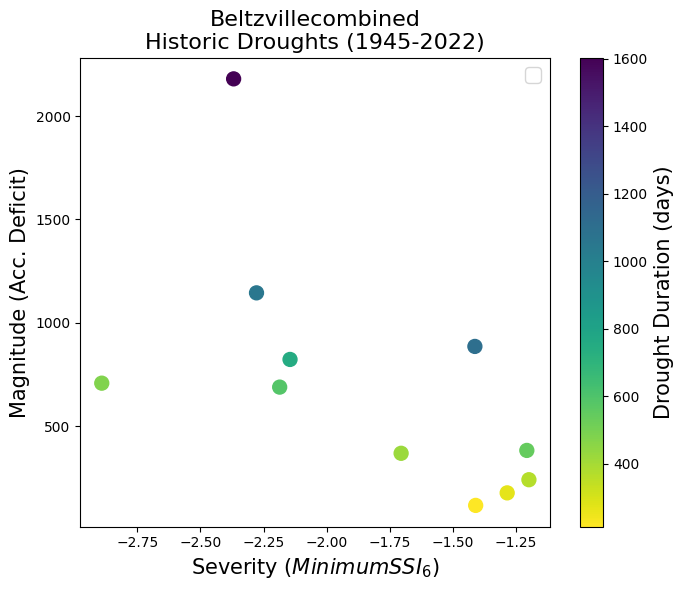

In [19]:
## Options
highlight_after_1970 = False

fig, ax = plt.subplots(figsize = (7,6))
# cmap = plt.get_cmap('Reds')
# norm = mpl.colors.Normalize(vmin=drought_metrics['severity'].min(), 
#                             vmax=drought_metrics['severity'].max())

# cs = cmap(norm(drought_metrics['severity'].values))
p = ax.scatter(drought_metrics['severity'], -drought_metrics['magnitude'],
           c= drought_metrics['duration'], cmap = 'viridis_r', s=100)

if highlight_after_1970:
    ax.scatter(drought_metrics.loc[drought_metrics['start'] > pd.to_datetime('1970-01-01'), 'severity'], 
               -drought_metrics.loc[drought_metrics['start'] > pd.to_datetime('1970-01-01'), 'magnitude'],
           edgecolors = 'darkorange', s=300, facecolors='none', linewidths=3,
           label = 'Droughts observed after 1970')


plt.colorbar(p).set_label(label = 'Drought Duration (days)',size=15)
plt.xlabel(r'Severity ($Minimum SSI_{6}$)', fontsize = 15)
plt.ylabel(r'Magnitude (Acc. Deficit)', fontsize = 15)
plt.title(f'{plot_nodes[0].capitalize()}\nHistoric Droughts (1945-2022)', fontsize = 16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# plt.yscale('log')
# plt.xscale('log')